In [ ]:
import pandas as pd
import re
import string
import spacy
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk import word_tokenize
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams.update({'font.size': 8})
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

我们主要采用pandas来导入数据，matplotlib进行绘图处理。对于探索性自然语言处理，我们主要使用nltk包来进行。最后几行代码规定了全局绘图的大小以及格式。没有最后一行代码指定以矢量图格式显示会导致pyplot绘制的图质量过低，难以阅读。

In [ ]:
train_data = pd.read_csv("/train.tsv/train.tsv",sep='\t',header=None,
                   names = ["index","sentence","phrase","sentiment"],dtype={"index":int,"sentence":int,"phrase":str,"sentiment":int})
print(train_data.head())

         index  sentence                                             phrase  \
0            1         1  A series of escapades demonstrating the adage ...   
1            2         1  A series of escapades demonstrating the adage ...   
2            3         1                                           A series   
3            4         1                                                  A   
4            5         1                                             series   
...        ...       ...                                                ...   
156055  156056      8544                                          Hearst 's   
156056  156057      8544                          forced avuncular chortles   
156057  156058      8544                                 avuncular chortles   
156058  156059      8544                                          avuncular   
156059  156060      8544                                           chortles   

        sentiment  
0               1  
1          

In [ ]:
test_data = pd.read_csv("/test.tsv/test.tsv",sep='\t',header=None,
                   names = ["index","sentence","phrase"],dtype={"index":int,"sentence":int,"phrase":str})
print(train_data.head())

为了处理的简便起见，我们在这一部分导入数据时在原始的tsv文件中把列名删除了，重新指定了列名并指定了每一列的数据类型，防止出现以外的类型转换问题。由之前的一些测试代码可以发现本数据的质量较好，没有缺失数据等，故不需要做这一步预处理。

该数据集由制表符分隔文件组成，其中包含来自Rotten Tomatoes数据集的短语。为了基准测试，保留了 train/test 拆分，但句子相对原始顺序，已重新排列。每个句子都已被 Stanford 解析器解析为许多短语。每个短语都有一个 PhraseId。每个句子都有一个 SentenceId。重复的短语（如短/常用词）在数据中仅包含一次。

train.tsv 包含短语及其关联的情绪标签。我们还提供了一个 SentenceId，以便您可以跟踪哪些短语属于单个句子。
test.tsv 仅包含短语。您必须为每个短语分配一个情绪标签。
情绪标签包括：

0 - negative

1 - somewhat negative

2 - neutral

3 - somewhat positive

4 - positive

## 探索性数据分析

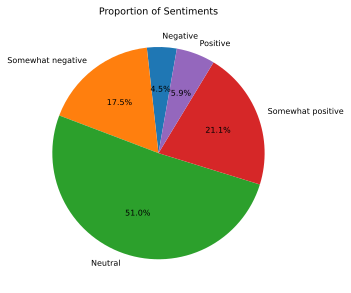

In [ ]:
train_data["phrase"] = train_data["phrase"].apply(lambda x: x.lower())
train_data["phrase"] = train_data["phrase"].apply(lambda x:re.sub('[%s]' % re.escape(string.punctuation), '', x))

train_data_copy=train_data.copy(deep=True)

plt.pie(train_data_copy['sentiment'].value_counts().sort_index(),
        labels=['Negative','Somewhat negative','Neutral','Somewhat positive','Positive'],
        autopct='%1.1f%%',
        startangle=80
        )
plt.title('Proportion of Sentiments')
plt.show()

我们在这一步做了文本数据的预处理和一个初步统计。为了消除常见的干扰信息，我们去除了文本中的标点符号并将所有字母转为小写字母。我们对于情感类型的分布做了统计，结果显示Neutral占了一半以上，而最确定的Negative和Positive占比最少。这也非常符合本组数据将一个句子做树状拆分后，大部分短语的情感色彩为Neutral的特点。

Text(0.5, 1.0, 'Histogram of Phrase Lengths Distribution')

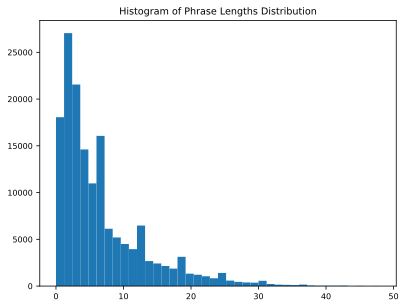

In [ ]:
train_data_copy['lens'] = train_data_copy['phrase'].apply(lambda x: len(x.split()))
train_data_copy['sentiment'] = train_data_copy['sentiment'].apply(lambda x: str(x).replace('0','Negative').replace('1','Somewhat negative').replace('2','Neutral').replace('3','Somewhat positive').replace('4','Positive'))
plt.hist(train_data_copy['lens'],bins=40)
plt.title('Histogram of Phrase Lengths Distribution')

然后我们分析了总体句长的分布。本组数据的句长分布呈现典型的偏态分布特征。结合数据的来源，可以推测其相对符合指数分布。

Text(0.5, 0.98, 'Histogram of Phrase Lengths Distribution By Sentiments')

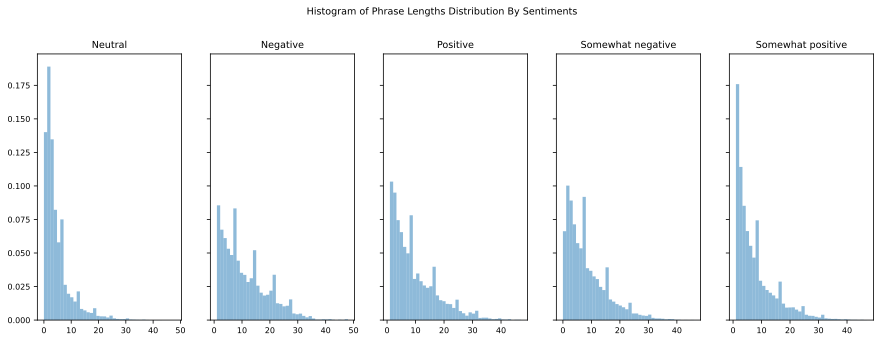

In [ ]:
df_neutral = train_data_copy[train_data_copy['sentiment'] == 'Neutral']
df_negative = train_data_copy[train_data_copy['sentiment'] == 'Negative']
df_positive = train_data_copy[train_data_copy['sentiment'] == 'Positive']
df_somewhat_negative = train_data_copy[train_data_copy['sentiment'] == 'Somewhat negative']
df_somewhat_positive = train_data_copy[train_data_copy['sentiment'] == 'Somewhat positive']

fig,(fig1,fig2,fig3,fig4,fig5) = plt.subplots(1,5,sharey="row",figsize=(15,5))
plt.subplots_adjust(top = 0.85)
fig1.hist(df_neutral['lens'],bins=40,label='Neutral',alpha=0.5,density=True)
fig1.set_title('Neutral')
fig2.hist(df_negative['lens'],bins=40,label='Negative',alpha=0.5,density=True)
fig2.set_title('Negative')
fig3.hist(df_positive['lens'],bins=40,label='Positive',alpha=0.5,density=True)
fig3.set_title('Positive')
fig4.hist(df_somewhat_negative['lens'],bins=40,label='Somewhat negative',alpha=0.5,density=True)
fig4.set_title('Somewhat negative')
fig5.hist(df_somewhat_positive['lens'],bins=40,label='Somewhat positive',alpha=0.5,density=True)
fig5.set_title('Somewhat positive')
plt.suptitle('Histogram of Phrase Lengths Distribution By Sentiments')

然后我们对于不同情感色彩的句长进行了分析，探讨其差异性。可以看到Neutral组的句长分布明显偏短，而注释有情感的短句长度会更高一些。但是所有组别的分布仍然都是短句远多于长句。这一方面说明了大部分短句可能都没有明显的感情色彩，另一方面也说明了长句的感情色彩仍然需要由决定性的短语来确定。

In [70]:
def WordFrecAnalysis(listA,outputnumber = 0):
    Estopwords = stopwords.words('english')
    Estopwords+=['movie','film','story','movies','one','two','people','films','work']
    
    wholelist = []
    for ps in listA:
        psT = word_tokenize(ps)
        psF = [word for word in psT if word not in Estopwords]
        wholelist+=psF
    fdist = FreqDist(wholelist)
    if outputnumber != 0:
        Common_words = fdist.most_common(outputnumber)
    else:
        Common_words = fdist.most_common()
    return Common_words
    

In [71]:
df_neutral_phrase = df_neutral["phrase"].tolist()
Neutral_Freq = WordFrecAnalysis(df_neutral_phrase,20)

In [72]:
df_negative_phrase = df_negative["phrase"].tolist()
Negative_Freq =WordFrecAnalysis(df_negative_phrase,20)

In [73]:
df_positive_phrase = df_positive["phrase"].tolist()
Positive_Freq = WordFrecAnalysis(df_positive_phrase,20)

In [74]:
df_somewhat_positive_phrase = df_somewhat_positive["phrase"].tolist()
Somewhat_positive_Freq = WordFrecAnalysis(df_somewhat_positive_phrase,20)

In [75]:
df_somewhat_negative_phrase = df_somewhat_negative["phrase"].tolist()
Somewhat_engative_Freq = WordFrecAnalysis(df_somewhat_negative_phrase,20)

In [86]:
def Plot_wordFrec(Freqlist):
    Wordlist = []
    freqList = []
    for word,freq in Freqlist:
        Wordlist.append(word)
        freqList.append(freq)
    plt.barh(Wordlist,freqList,alpha=0.5)   

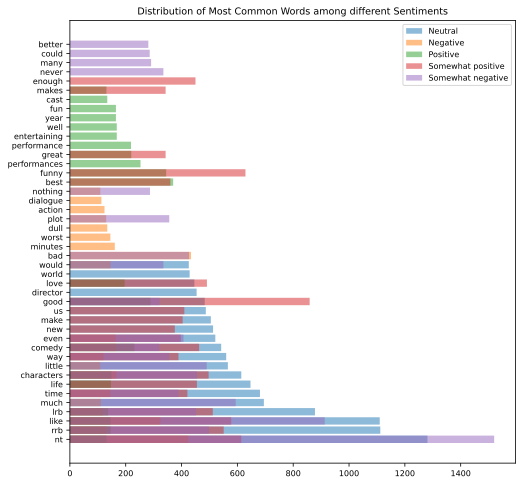

In [87]:
plt.figure(figsize=(8,8))
Plot_wordFrec(Neutral_Freq)
Plot_wordFrec(Negative_Freq)
Plot_wordFrec(Positive_Freq)
Plot_wordFrec(Somewhat_positive_Freq)
Plot_wordFrec(Somewhat_engative_Freq)
plt.legend(['Neutral','Negative','Positive','Somewhat positive','Somewhat negative'])
plt.title('Distribution of Most Common Words among different Sentiments')
plt.show()


随后我们利用nltk进行了一个初步的词频分析.选取了每组词频前20位的词语，并在常规禁用词外增加了我们前期看到的一些在本任务中比较常见但没有很大价值的词汇。可以看到特别高频出现的词汇依旧没有太大的感情色彩，在各组之间均有分布。但是次高频出现的词汇就能体现出比较明显的感情色彩。这提示这些次高频词汇可能是分析文本感情的关键。

## 文本向量化

我们采用了两种文本向量化的方法：

1. Bag-of-Words模型：将文本中的每个词语视为一个特征，每个词语出现的次数作为该特征的权重。	
2. TF-IDF模型：词频-逆文档频率模型，是一种统计方法，它是一种基于词袋模型的文本特征提取方法。词频（TF）表示词语在文本中出现的次数。逆文档频率（IDF）表示词语在整个语料库中出现的次数。IDF这个值越大，则该词语的重要性越低。TF-IDF模型通过对每个词语的TF-IDF值进行加权，得到每个短句的权重。

关于向量化后矩阵的具体意义，可以参考这篇文章：  
[【Python数据分析】文本情感分析——电影评论分析（二）文本向量化建立模型总结与改进方向](https://www.cnblogs.com/gc2770/p/14929162.html)  
### 词袋模型

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

# 将短语和标签提取出来
X = train_data['Phrase']  # 短语
y = train_data['Sentiment']  # 情感标签

# 将数据拆分为训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 文本向量化
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)


In [ ]:
print(X_train_vec)
print("词频矩阵：", X_train_vec.toarray())

  (0, 2244)	1
  (1, 14262)	1
  (1, 11383)	1
  (2, 14939)	1
  (2, 8967)	1
  (2, 506)	1
  (2, 13499)	1
  (2, 8052)	1
  (2, 13532)	1
  (2, 1962)	1
  (2, 8855)	1
  (2, 7419)	1
  (2, 5098)	1
  (2, 9377)	1
  (2, 14902)	2
  (2, 6784)	1
  (2, 13550)	1
  (2, 10261)	1
  (2, 8466)	1
  (3, 12431)	1
  (3, 1355)	1
  (3, 12256)	1
  (3, 1430)	1
  (3, 624)	1
  (3, 12484)	1
  :	:
  (124845, 9225)	1
  (124845, 8027)	1
  (124845, 13302)	1
  (124845, 14204)	1
  (124845, 8798)	1
  (124845, 3592)	1
  (124845, 9930)	1
  (124846, 506)	1
  (124846, 9377)	1
  (124846, 624)	1
  (124846, 15173)	1
  (124846, 9324)	1
  (124846, 7228)	1
  (124846, 1893)	1
  (124846, 8027)	1
  (124846, 6649)	1
  (124846, 13515)	1
  (124846, 10026)	1
  (124846, 10731)	1
  (124846, 8375)	1
  (124846, 2228)	1
  (124847, 624)	1
  (124847, 972)	1
  (124847, 4014)	1
  (124847, 4507)	1
词频矩阵： [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
print(X_val_vec)
print("词频矩阵:", X_val_vec.toarray())

  (0, 855)	1
  (0, 12464)	1
  (1, 137)	1
  (1, 624)	1
  (1, 1208)	1
  (1, 1246)	1
  (1, 1878)	1
  (1, 2585)	1
  (1, 2641)	1
  (1, 3448)	1
  (1, 3926)	1
  (1, 5117)	1
  (1, 6307)	1
  (1, 8339)	1
  (1, 9211)	1
  (1, 9377)	1
  (1, 11326)	1
  (1, 11747)	1
  (1, 13532)	1
  (1, 13675)	1
  (1, 13989)	1
  (2, 3310)	1
  (2, 9225)	1
  (2, 13528)	1
  (3, 5241)	1
  :	:
  (31202, 13675)	2
  (31203, 1799)	1
  (31204, 624)	1
  (31204, 4499)	1
  (31204, 6995)	1
  (31205, 4744)	1
  (31205, 13063)	1
  (31206, 6710)	1
  (31206, 10164)	1
  (31206, 13499)	1
  (31207, 4566)	1
  (31207, 5414)	1
  (31208, 6630)	1
  (31208, 15056)	1
  (31209, 465)	1
  (31209, 2732)	1
  (31209, 6784)	1
  (31209, 13499)	2
  (31209, 13500)	1
  (31210, 2435)	1
  (31210, 3203)	1
  (31210, 10054)	1
  (31211, 2386)	1
  (31211, 13499)	1
  (31211, 14719)	1
词频矩阵: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
# 密集矩阵
X_train_vec.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [ ]:
X_val_vec

<31212x15228 sparse matrix of type '<class 'numpy.int64'>'
	with 194056 stored elements in Compressed Sparse Row format>

Countvectorizer只会对字符长度不小于2的单词进行处理，如果单词只包含一个字符，这个单词就会被忽略。 注意 ，经过训练后，CountVectorizer就可以对测试集文件进行向量化了，但是向量化出来的特征只是训练集出现的单词特征，如果测试集出现了训练集中没有的单词，就无法在词袋模型中体现了。


In [ ]:
# 使用朴素贝叶斯分类器进行训练
model = MultinomialNB()
model.fit(X_train_vec, y_train)


MultinomialNB()

In [ ]:
# 在验证集上进行预测
y_val_pred = model.predict(X_val_vec)

# 输出分类报告
print(classification_report(y_val, y_val_pred))


              precision    recall  f1-score   support

           0       0.44      0.29      0.35      1416
           1       0.50      0.44      0.47      5527
           2       0.69      0.78      0.73     15639
           3       0.53      0.50      0.51      6707
           4       0.49      0.34      0.40      1923

    accuracy                           0.61     31212
   macro avg       0.53      0.47      0.49     31212
weighted avg       0.60      0.61      0.60     31212



In [ ]:
# 对于测试集进行预测

X_test = test_data['Phrase']

# 文本向量化测试集
X_test_vec = vectorizer.transform(X_test)

# 进行情感预测
y_test_pred = model.predict(X_test_vec)


In [ ]:
# 将预测结果保存到文件
submission = pd.DataFrame({'PhraseId': test_data['PhraseId'], 'Sentiment': y_test_pred})
print(submission)
# submission.to_csv(r'submission_bagging.csv', index=False)

# 疑似测试集有空数据导致无法转换为向量，因此需要做一下处理
# 参考：https://stackoverflow.com/questions/47064518/sklearn-text-vectorization-valueerror-input-contains-nan-infinity-or-a-value-too-larg


### TF-IDF转换
scikit-learn库中的tf-idf转换与标准公式稍微不同，而且tf-idf结果会用L1或L2范数进行标准化。

In [ ]:
# TF-IDF 文本向量化
# 可以采用nltk包的标准公式代替这个算法 --zyy
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
# TfidfVectorizer 结合了 CountVectorizer 和 TfidfTransformer 的功能
# 可以直接将文本数据转换为 TF-IDF 表示。

In [ ]:
vectorizer2 = TfidfVectorizer(stop_words='english')
X_train_vec2 = vectorizer2.fit_transform(X_train)
X_val_vec2 = vectorizer2.transform(X_val)

print(X_train_vec2.toarray())
print(X_val_vec2.toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
# 使用朴素贝叶斯分类器进行训练
model2 = MultinomialNB()
model2.fit(X_train_vec2, y_train)

y_val_pred2 = model2.predict(X_val_vec2)
print(classification_report(y_val, y_val_pred2))


              precision    recall  f1-score   support

           0       0.65      0.05      0.09      1416
           1       0.52      0.28      0.36      5527
           2       0.61      0.89      0.72     15639
           3       0.53      0.40      0.46      6707
           4       0.66      0.06      0.11      1923

    accuracy                           0.59     31212
   macro avg       0.59      0.33      0.35     31212
weighted avg       0.58      0.59      0.53     31212



In [ ]:
# 预测测试集
X_test_vec2 = vectorizer2.transform(X_test)
y_test_pred2 = model2.predict(X_test_vec2)

submission2 = pd.DataFrame({'PhraseId': test_data['PhraseId'], 'Sentiment': y_test_pred})
print(submission2)
# submission2.to_csv(r'submission_tfidf_MutiNB.csv', index=False)